# ESE 527 Project - Jeremiah Lee

## 1) Data Cleaning\Formatting and Data Exploration

First, we want to get an understanding of what the landscape of this data is. Using a heuristic approach towards selecting what we want to explore,  There are several factors to keep in mind with the scope of the problem. First, this dataset is for the city of New York, which does have an extensive public transportation system as well as large amounts of traffic congestion. Second, is the typical usage of an Uber given the availability of public transportation in NY. We select an observation of the distributions of when rides occur across weekdays/weekends.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from matplotlib.pyplot import figure

#import yellowbrick
#from yellowbrick.cluster import SilhouetteVisualizer
#Yellowbricks is deprecated-> too many environment issues with incompatible packages and versions of sklearn...

,,Date/Time
DayOfWeekNum,DayOfWeek,
0,Monday,60861
1,Tuesday,91185
2,Wednesday,108631
3,Thursday,85067
4,Friday,90303
5,Saturday,77218
6,Sunday,51251


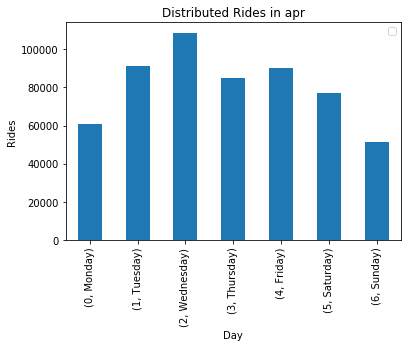

<Figure size 3200x2560 with 0 Axes>

,,Date/Time
DayOfWeekNum,DayOfWeek,
0,Monday,63846
1,Tuesday,76662
2,Wednesday,89857
3,Thursday,128921
4,Friday,133991
5,Saturday,102990
6,Sunday,56168


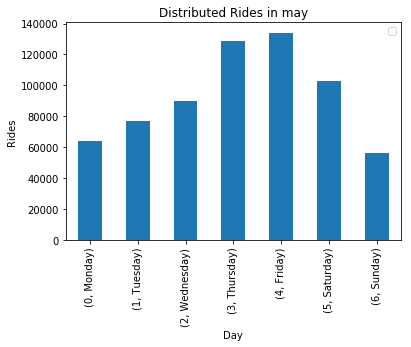

<Figure size 3200x2560 with 0 Axes>

,,Date/Time
DayOfWeekNum,DayOfWeek,
0,Monday,94655
1,Tuesday,88134
2,Wednesday,99654
3,Thursday,115325
4,Friday,105056
5,Saturday,81364
6,Sunday,79656


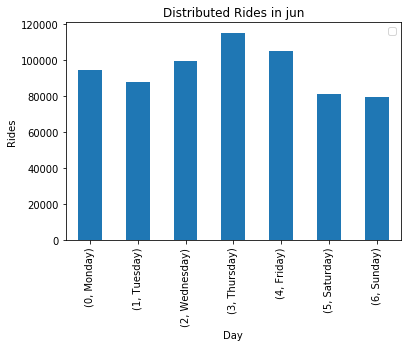

<Figure size 3200x2560 with 0 Axes>

,,Date/Time
DayOfWeekNum,DayOfWeek,
0,Monday,93189
1,Tuesday,137454
2,Wednesday,147717
3,Thursday,148439
4,Friday,102735
5,Saturday,90260
6,Sunday,76327


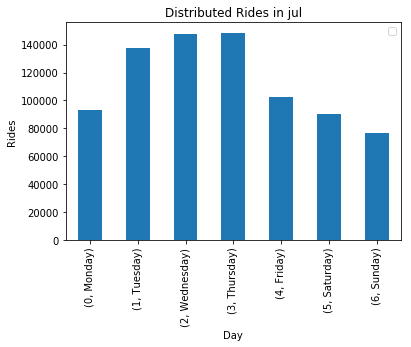

<Figure size 3200x2560 with 0 Axes>

,,Date/Time
DayOfWeekNum,DayOfWeek,
0,Monday,91633
1,Tuesday,107124
2,Wednesday,115256
3,Thursday,124117
4,Friday,148674
5,Saturday,132225
6,Sunday,110246


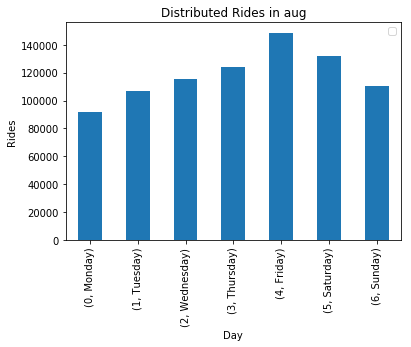

<Figure size 3200x2560 with 0 Axes>

,,Date/Time
DayOfWeekNum,DayOfWeek,
0,Monday,137288
1,Tuesday,163230
2,Wednesday,135373
3,Thursday,153276
4,Friday,160380
5,Saturday,162057
6,Sunday,116532


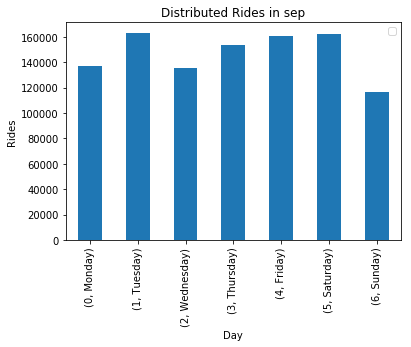

<Figure size 3200x2560 with 0 Axes>

In [2]:
#2014 Data Apr-Sept Uber
def showDist_dayofweek (monthName):
    csvFile = "uber-raw-data-"+monthName+"14.csv"
    month_df= pd.read_csv(csvFile, sep=',')
    #Dropping columns that are not needed for this section
    month_df.drop('Lat', axis=1, inplace=True)
    month_df.drop('Lon', axis=1, inplace=True)
    month_df.drop('Base', axis=1, inplace=True)

    month_df['Date/Time'] = pd.to_datetime(month_df['Date/Time'], format="%m/%d/%Y %H:%M:%S")
    #Need to Normalize
    
    #Determine the day of week from date/time 
    month_df['DayOfWeekNum'] = month_df['Date/Time'].dt.dayofweek
    month_df['DayOfWeek'] = month_df['Date/Time'].dt.day_name()
    #month_df['HourOfDay'] = month_df['Date/Time'].dt.hour
    #month_df['MinuteOfDay'] = month_df['Date/Time'].dt.minute
    #display(month_df)
    month_days = month_df.pivot_table(index=['DayOfWeekNum','DayOfWeek'],
                                      aggfunc='count')
    display(month_days)
    #month_days=month_days[:,1:]
    
    #Plotting and formatting
    month_days.plot(kind='bar')
    plt.legend([])
    plt.ylabel('Rides')
    plt.xlabel('Day')
    plt.title('Distributed Rides in ' + monthName)
    figure(figsize=(20, 16), dpi=160)
    plt.show()
    

mset=["apr", "may", "jun", "jul", "aug", "sep"]
for mname in mset:
    showDist_dayofweek(mname)

#showDist_dayofweek("aug")

### Min, Max, Range
Minimum= Sundays in April: 51,251
<br>
Maximum= Wednesdays in September: 163,230
<br>
Range= 111,879
<br>
<br>
### Day of Week Totals
Monday Totals= 541,472
<br>
Tuesday Totals= 663,789
<br>
Wednesday Totals= 696,488
<br>
Thursday Totals= 755,145
<br>
Friday Totals= 741,139
<br>
Saturday Totals= 646,114
<br>
Sunday Totals= 490,180

## 2) Data Set and Problem Size Reduction

The data set has an incredibly large amount of data to process, which is infeasible to operate on within the bounds of a semester long project with individual resources. As such, we want to downsample the data to a smaller size while still maintaining the underlying distributions. First, the possibility of restricting the boundaries of the problem to the borders of Manhattan, then potentially a specific neighborhood within Manhattan. Other possible options to explore are the selection of specific hour/time periods.

Issues with reverse Geocoding: There are no free services that would provide reverse geocoding of this many data points in either a feasible amount of time or with reasonable pricing structure for this course. They are furthermore rate limited. Ideally, this would be done to get addresses using lat/lon. Filtering out those points in neighborhoods that are not desired would be done from there. 

Explored APIs running with the 500k data points we have in only April make a ton of calls to services which costs a ton, especially services that have the resolution that we need (i.e. street address).


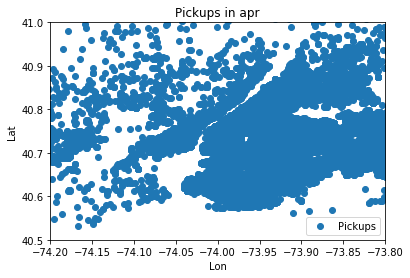

In [3]:
def showDist_loc (monthName):
    csvFile = "uber-raw-data-"+monthName+"14.csv"
    month_df= pd.read_csv(csvFile, sep=',')
    #Dropping columns that are not needed for this section
    month_df.drop('Date/Time', axis=1, inplace=True)
    month_df.drop('Base', axis=1, inplace=True)
    #display(month_df)
    plt.rcParams['agg.path.chunksize'] = 1000000
    #Plotting and formatting
    plt.scatter(x=month_df['Lon'],y= month_df['Lat'])
    plt.legend(['Pickups'])
    plt.rcParams['figure.figsize'] = [40, 40]
    plt.ylabel('Lat')
    plt.xlabel('Lon')
    plt.ylim([40.5, 41])
    plt.xlim([-74.2, -73.8])
    plt.title('Pickups in ' + monthName);
    plt.show()
    
mset=["apr"]
for mname in mset:
    showDist_loc(mname)

## 3) Modeling
K-means clustering: Find cluster centers. 
To determine the k value, use the Elbow method.

In [6]:
def readInDf(monthName):
    csvFile = "uber-raw-data-"+monthName+"14.csv"
    month_df= pd.read_csv(csvFile, sep=',')
    return month_df

def dropPointsLatLon (monthName):
    month_df=readInDf(monthName)
    
    #Dropping columns that are not needed for this section
    month_df.drop('Date/Time', axis=1, inplace=True)
    month_df.drop('Base', axis=1, inplace=True)
    
    #Visual restriction to the area around manhattan (Midtown)
    month_df=month_df[month_df["Lat"]>40.74]
    month_df=month_df[month_df["Lat"]<40.758]
    month_df=month_df[month_df["Lon"]<-73.9717]
    month_df=month_df[month_df["Lon"]>-73.99]
    month_df=month_df.reset_index(drop=True)
    
    #theta=np.radians(30)

    #In [x]: c, s = np.cos(theta), np.sin(theta)
    #In [x]: R = np.array(((c, -s), (s, c)))
    #month_df['Lat']
    #EVEN SMALLERR
    #month_df=month_df[month_df["Lat"]>40.745] #lower bound Lat
    #month_df=month_df[month_df["Lat"]<40.750] #upper bound Lat
    #month_df=month_df[month_df["Lon"]<-73.975] #upper bound Lon
    #month_df=month_df[month_df["Lon"]>-73.99] #lower bound Lon
    #month_df=month_df.reset_index(drop=True)
    
    return month_df

def dropPoints (monthName):
    month_df=readInDf(monthName)

    #Visual restriction to the area around manhattan (Midtown)
    month_df=month_df[month_df["Lat"]>40.74]
    month_df=month_df[month_df["Lat"]<40.758]
    month_df=month_df[month_df["Lon"]<-73.9717]
    month_df=month_df[month_df["Lon"]>-73.99]
    month_df=month_df.reset_index(drop=True)
    
    #month_df['Lat']
    #EVEN SMALLERR
    #month_df=month_df[month_df["Lat"]>40.745] #lower bound Lat
    #month_df=month_df[month_df["Lat"]<40.750] #upper bound Lat
    #month_df=month_df[month_df["Lon"]<-73.975] #upper bound Lon
    #month_df=month_df[month_df["Lon"]>-73.99] #lower bound Lon
    #month_df=month_df.reset_index(drop=True)
    
    return month_df    

#limit lat lon to around midtown
def showDist_droppedPoints (monthName):
    month_df=dropPointsLatLon(monthName)
    #Still 487,985 points after bounding general NY-> might have to be neighborhood specific (Midtown?)
    #68.9k points for area around Midtown
    #display(month_df)
    plt.rcParams['agg.path.chunksize'] = 1000000
    
    #Plotting and formatting
    plt.scatter(x=month_df['Lon'],y= month_df['Lat'])
    plt.legend(['Pickups'])
    plt.rcParams['figure.figsize'] = [40, 40]
    plt.ylabel('Lat')
    plt.xlabel('Lon')
    plt.title('Pickups in ' + monthName);
    plt.show()



def kmeansElbow (monthName):
    month_df=dropPointsLatLon(monthName)
    #Elbow method of K selection, code from:https://pythonprogramminglanguage.com/kmeans-elbow-method/. Tried using 
    #Yellowbrick, but had too many environment issues.
    plt.plot()
    colors = ['b', 'g', 'r']
    markers = ['o', 'v', 's']
    distortions=[]
    K=range(1,150)
    for k in K:
        kModel=KMeans(n_clusters=k).fit(month_df)
        kModel.fit(month_df)
        distortions.append(sum(np.min(cdist(month_df, kModel.cluster_centers_,'euclidean'), axis=1))/month_df.shape[0])
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
mset=["apr"]

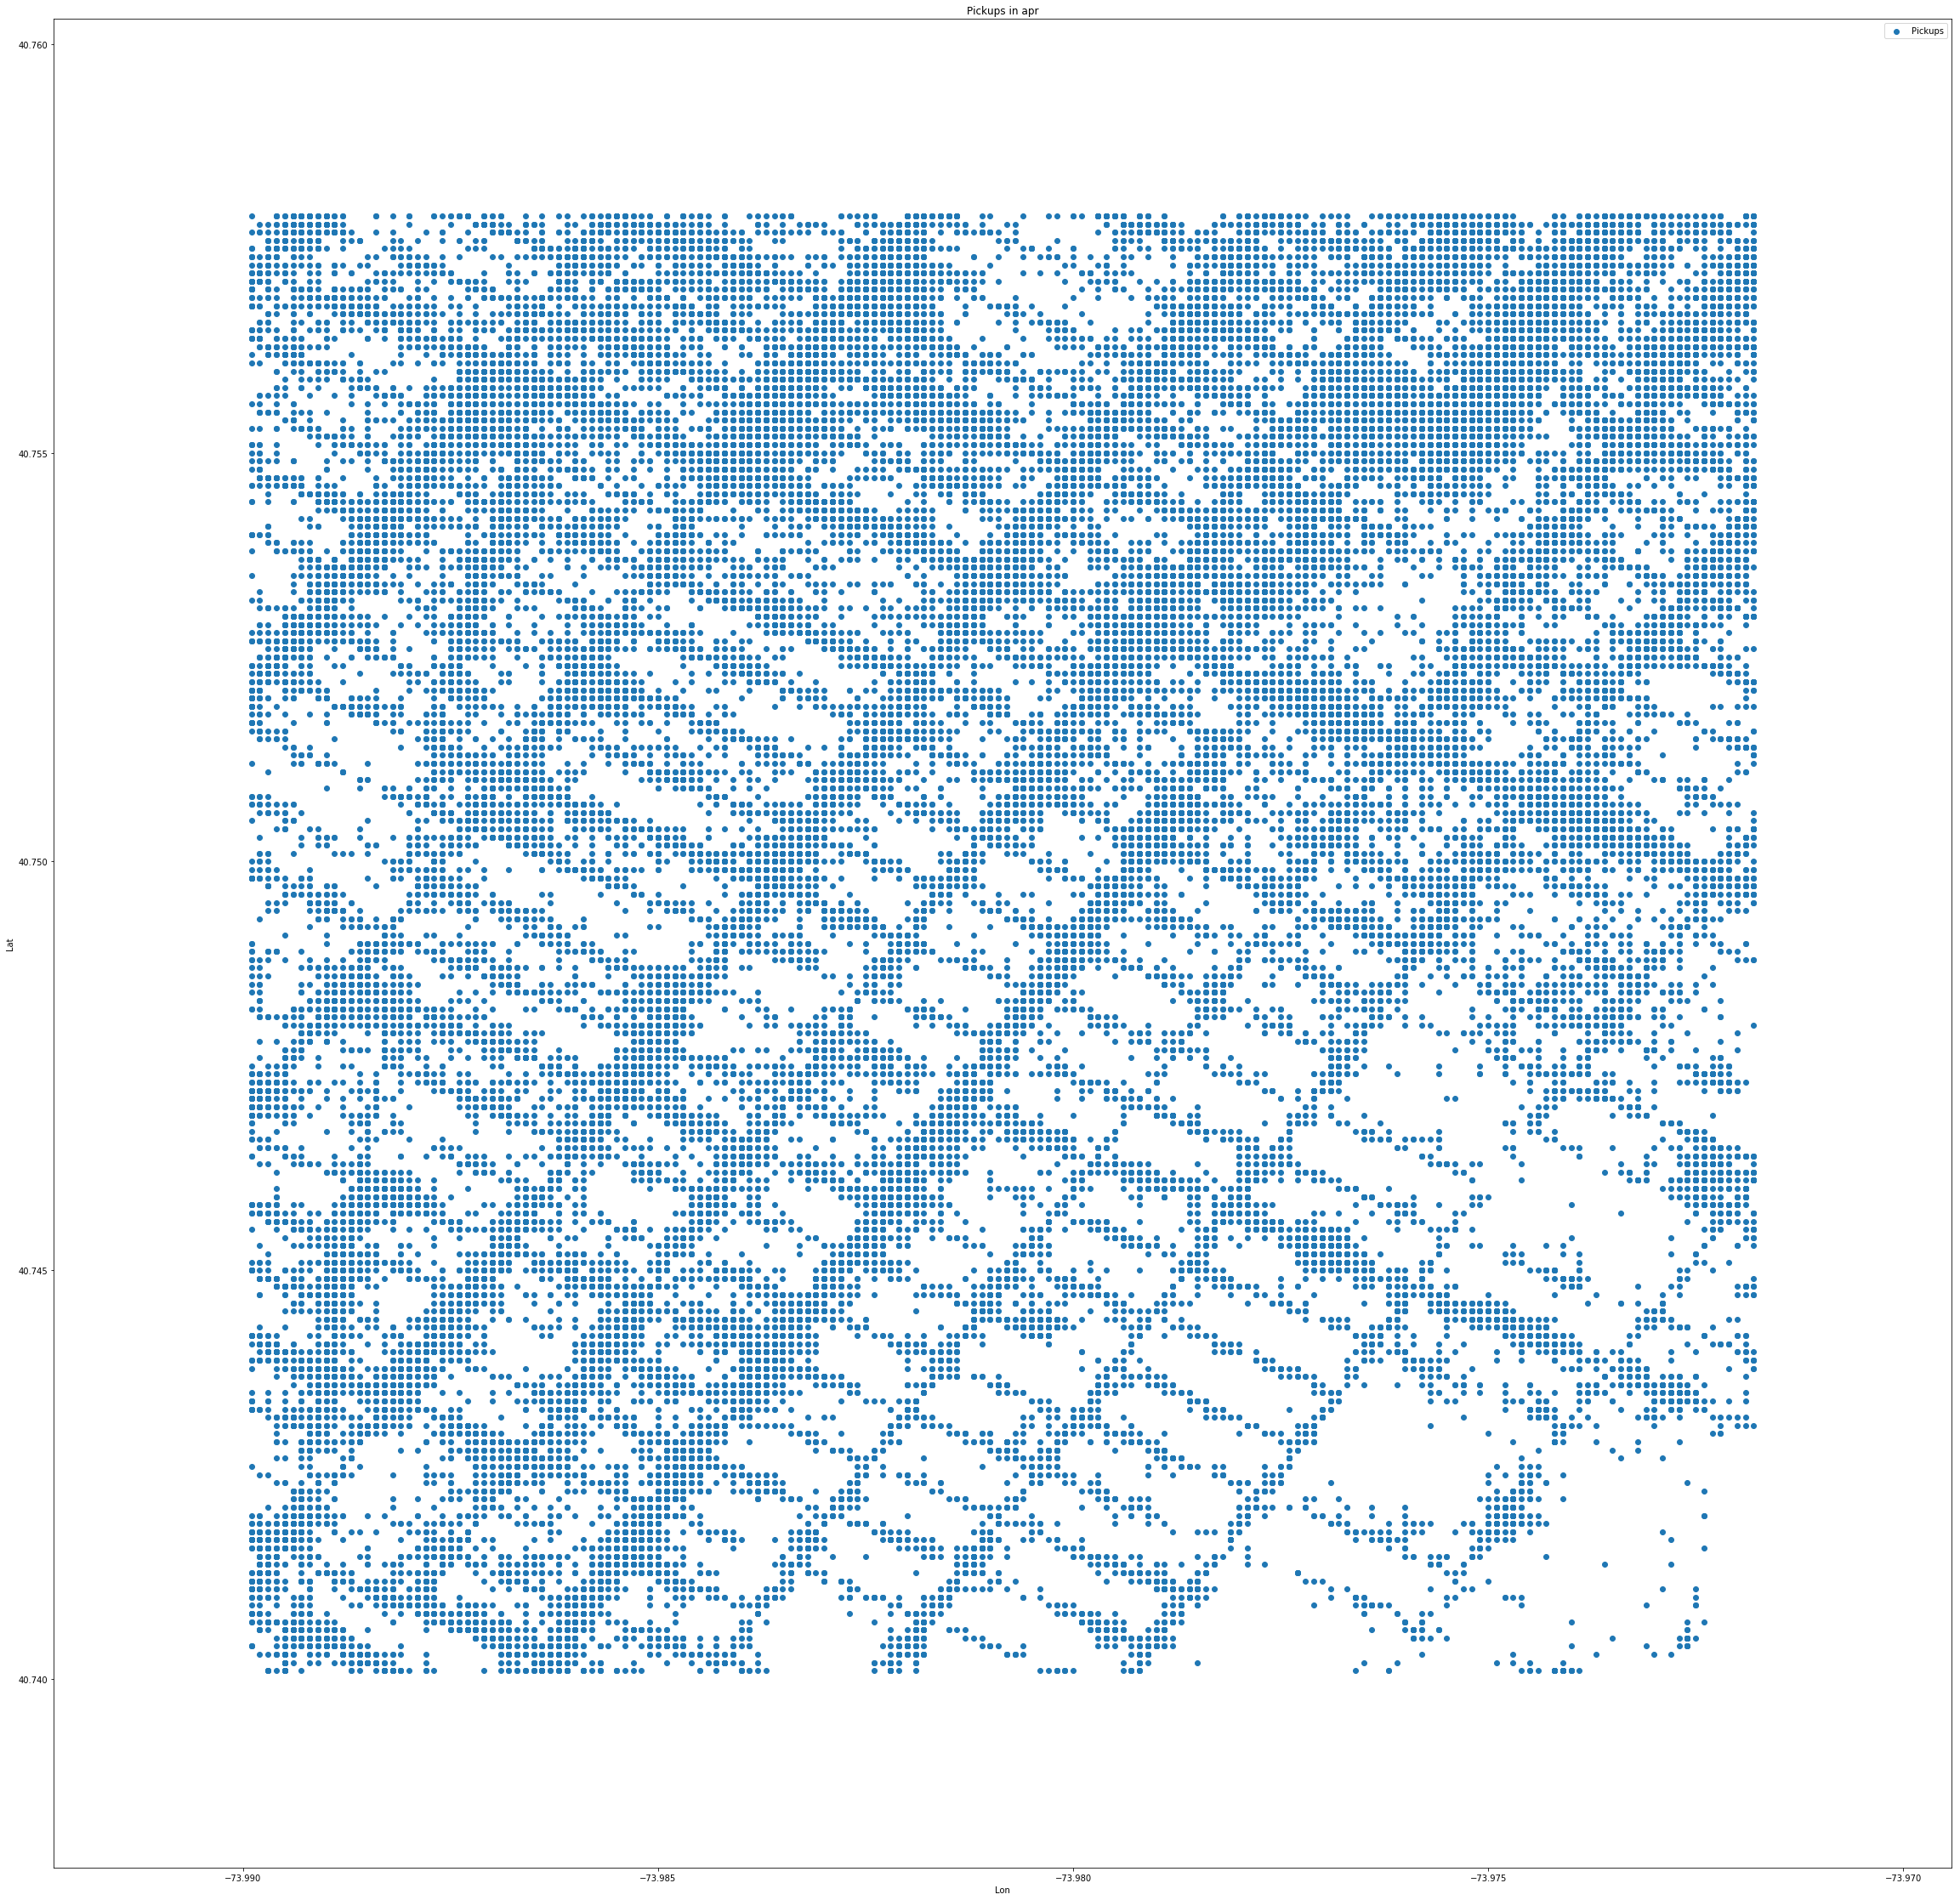

In [7]:
for mname in mset:
    showDist_droppedPoints(mname)

In [11]:
#for mname in mset:
   # kmeansElbow(mname)

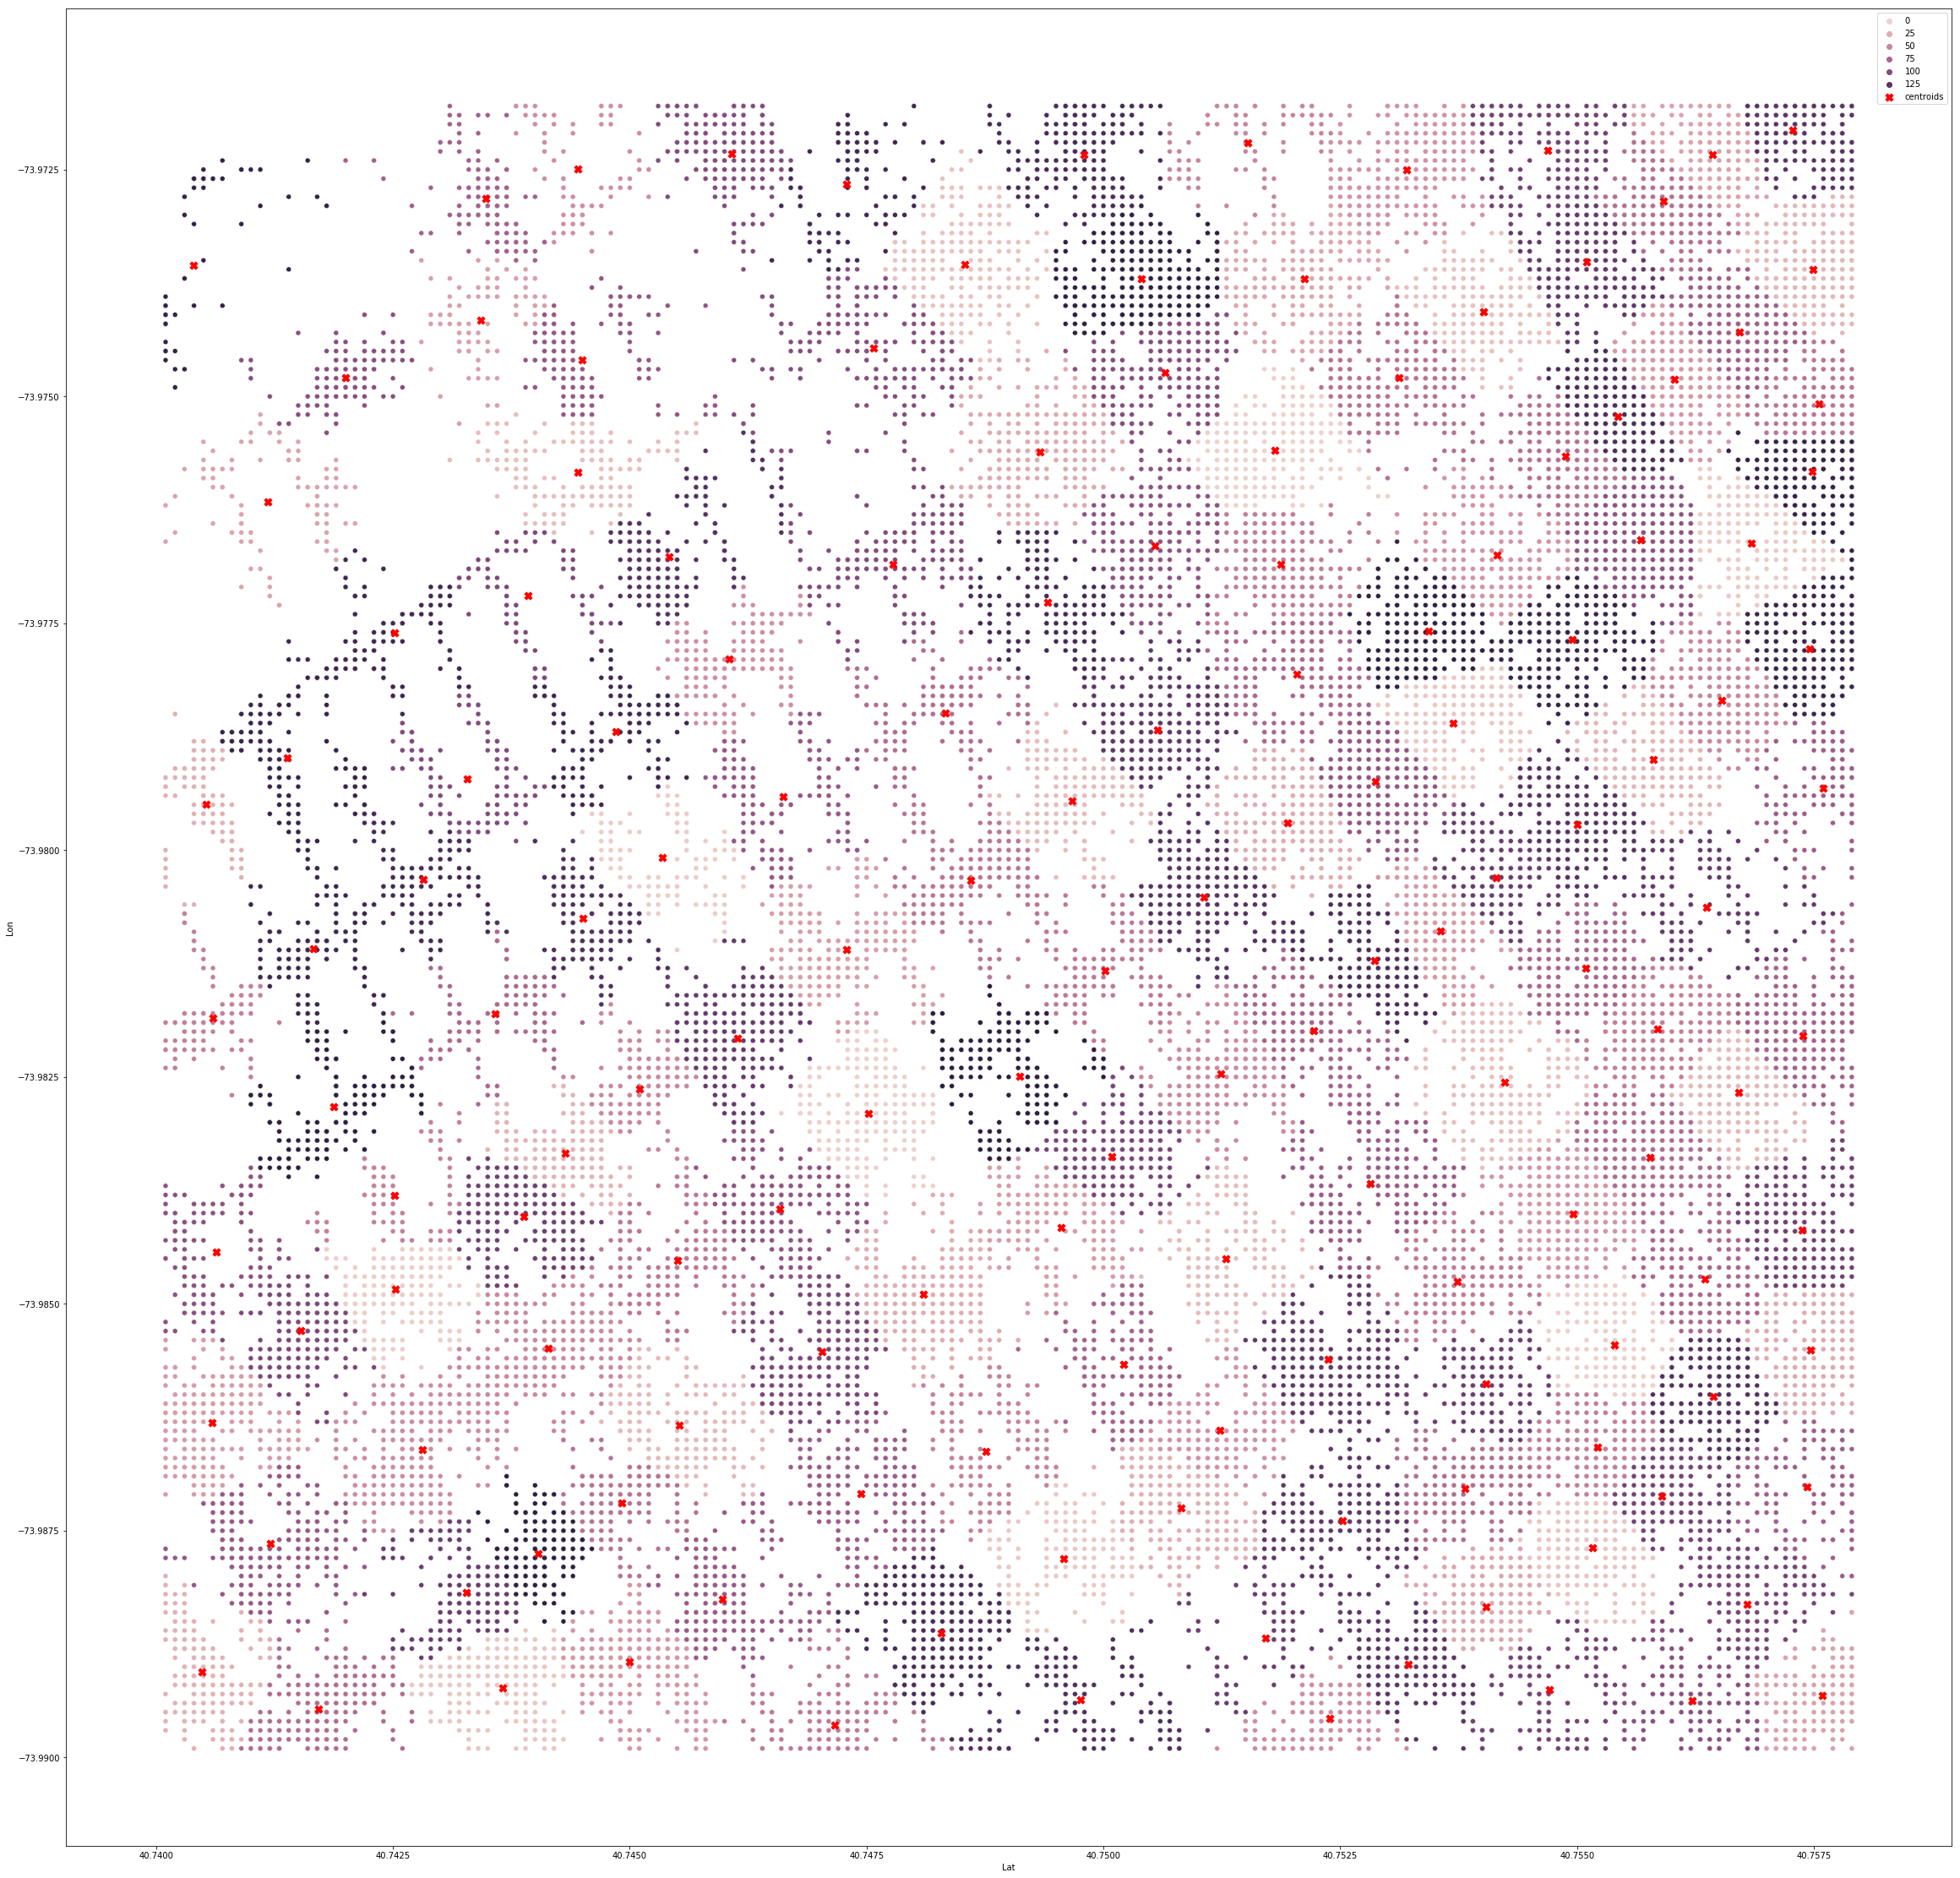

In [12]:
#Kmeans reference code: https://www.reneshbedre.com/blog/kmeans-clustering-python.html
import seaborn as sns
def kmeansRun (monthName):
    month_df=dropPointsLatLon(monthName)
    
    #SKlearn only has euclidean distance for kmeans calculation...
    #need to impose constraints on distance from cluster
    #Number of cluster selected from Elbow method
    kMeansModel=KMeans(n_clusters=150, init='k-means++', random_state=0).fit(month_df)
    sns.scatterplot(data=month_df, x="Lat", y="Lon", hue=kMeansModel.labels_)
    #sns.regplot(x=month_df["Lat"], y=month_df["Lon"], fit_reg=False)
    plt.scatter(kMeansModel.cluster_centers_[:,0], kMeansModel.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")
    plt.legend()
    plt.show()
    
mset=["apr"]
for mname in mset:
    kmeansRun(mname)
    

In [13]:
#WIP Function->Ignore this function, I was being stupid
def showDist_timeIntervals (monthName):
    month_df=dropPoints(monthName)
    month_df['Date/Time'] = pd.to_datetime(month_df['Date/Time'], format="%m/%d/%Y %H:%M:%S")
    #month_df['DayOfWeekNum'] = month_df['Date/Time'].dt.dayofweek
    #month_df['DayOfWeek'] = month_df['Date/Time'].dt.day_name
    month_df['HourOfDay'] = month_df['Date/Time'].dt.hour
    month_df['MinuteOfDay'] = month_df['Date/Time'].dt.minute
    
    month_df.drop('Lat', axis=1, inplace=True)
    month_df.drop('Lon', axis=1, inplace=True)
    month_df.drop('Base', axis=1, inplace=True)
    
    Interval_List=[]
    month_df.index=pd.to_datetime(month_df.index)
    for group in month_df.groupby(month_df.index.date):
        Interval_List.append(group[1])
        print(Interval_List)
    
showDist_timeIntervals("apr")

[                                        Date/Time  HourOfDay  MinuteOfDay
1970-01-01 00:00:00.000000000 2014-04-01 01:01:00          1            1
1970-01-01 00:00:00.000000001 2014-04-01 05:52:00          5           52
1970-01-01 00:00:00.000000002 2014-04-01 05:56:00          5           56
1970-01-01 00:00:00.000000003 2014-04-01 05:56:00          5           56
1970-01-01 00:00:00.000000004 2014-04-01 06:08:00          6            8
...                                           ...        ...          ...
1970-01-01 00:00:00.000068925 2014-04-30 22:28:00         22           28
1970-01-01 00:00:00.000068926 2014-04-30 22:29:00         22           29
1970-01-01 00:00:00.000068927 2014-04-30 22:51:00         22           51
1970-01-01 00:00:00.000068928 2014-04-30 22:58:00         22           58
1970-01-01 00:00:00.000068929 2014-04-30 23:31:00         23           31

[68930 rows x 3 columns]]


In [84]:
#Filter data to localized area (Midtown) 
df=pd.read_csv('uber-raw-data-apr14.csv')
df['date_time']=pd.to_datetime(df['Date/Time'])
df['date']=df['date_time'].map(lambda x:x.date())
df['month']=df['date_time'].map(lambda x:x.month)
df['hour']=df['date_time'].map(lambda x:x.hour)
df['minute']=df['date_time'].map(lambda x:x.minute)
df['weekday']=df['date_time'].map(lambda x:x.weekday())
df['day']=df['date_time'].map(lambda x:x.day)
df=df[df["Lat"]>40.74]
df=df[df["Lat"]<40.758]
df=df[df["Lon"]<-73.9717]
df=df[df["Lon"]>-73.99]

#Modified to drop weekends due to seasonality
df=df[df["weekday"]<5]

hourly_df={}
for day in range(1,31):
    temp=df[df['day']==day].copy()
    for hour in range(0,23):
        hourly_df[(day,hour)]=temp[temp['hour']==hour].copy()
        
c=list(map(lambda x:len(x[1]),hourly_df.items()))

In [81]:
#Kmeans reference code: https://www.reneshbedre.com/blog/kmeans-clustering-python.html
import seaborn as sns
def kmeansRun (df,k=7):

    #SKlearn only has euclidean distance for kmeans calculation...
    #need to impose constraints on distance from cluster
    #Number of cluster selected from Elbow method
    result=[]
    result.append(KMeans(n_clusters=k, init='k-means++', random_state=0).fit(df[['Lat','Lon']]).cluster_centers_)
    return result

def kmeansElbow (df, verbose):
    plt.plot()
    colors = ['b', 'g', 'r']
    markers = ['o', 'v', 's']
    plt.rcParams['figure.figsize'] = [10, 10]
    distortions=[]
    K=range(1,20)
    for k in K:
        kModel=KMeans(n_clusters=k,init='k-means++', random_state=0).fit(df[['Lat','Lon']])
        kModel.fit(df[['Lat','Lon']])
        distortions.append(sum(np.min(cdist(df[['Lat','Lon']], kModel.cluster_centers_,'euclidean'), axis=1))/df[['Lat','Lon']].shape[0])
    if verbose==1:
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method showing the optimal k')
        plt.show()
    
result={}
for key in hourly_df.keys():
    #Skip days with less than 30 pickups within a particular hour
    if len(hourly_df[key])>30:
        #kmeansElbow(hourly_df[key], 0)
        result[key]=kmeansRun(hourly_df[key])[:]
    else:
        result[key]=None

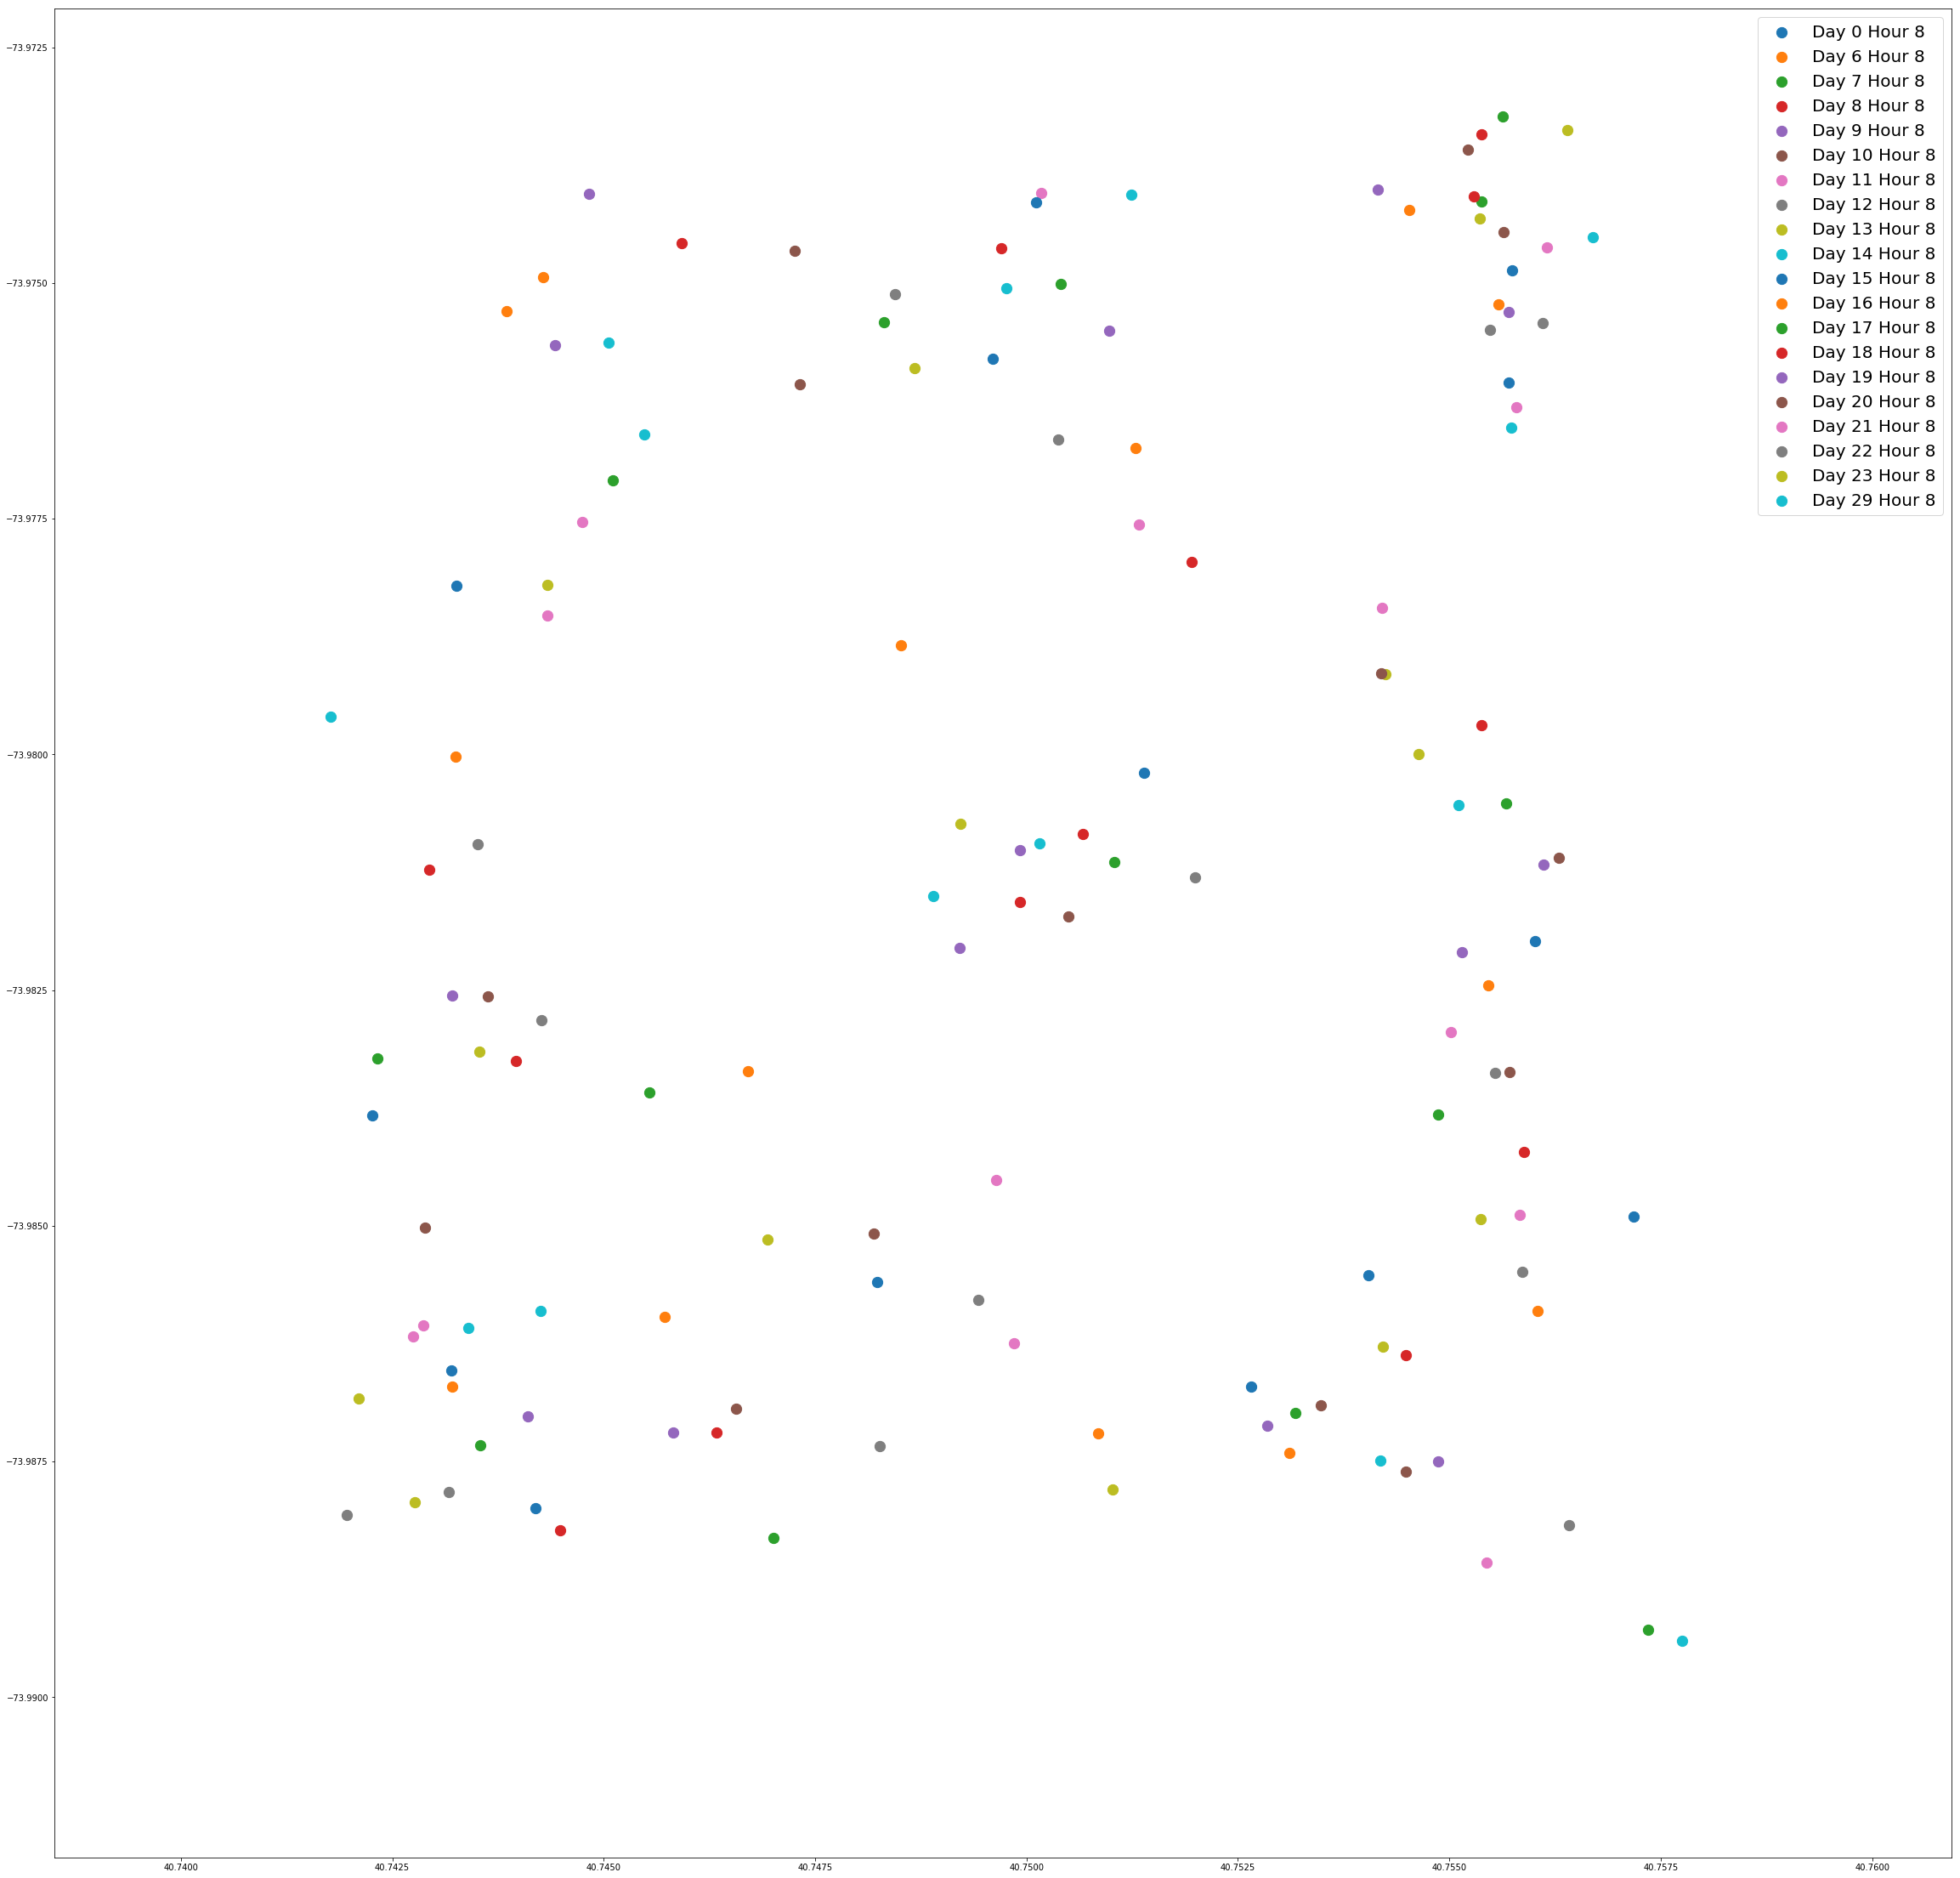

In [82]:
#Modified plotting function 
t=list(map(lambda x:x[1]!=None,result.items()))
sum(t)/len(t)
t=result.keys()
c=list(map(lambda x:x[1],result.items()))
res=[]
for item in c:
    if item==None:
        res.append(None)
    else:
        res.append((item[0][:,0].tolist(),item[0][:,1].tolist()))
        i=0

res0=pd.DataFrame()
for d in range(1,31):
    for h in range(24):
        if h!=8:
            continue
        else:
            if res[i]!=None:
                plt.scatter(res[i][0],res[i][1],label=f'Day {i} Hour 8', s=150)
                
                data={'Lat':res[i][0], 'Lon':res[i][1]}
                res0=res0.append(pd.DataFrame(data))
        i+=1
        
res0=res0.reset_index(drop=True)
#display(res0)

plt.rcParams['figure.figsize'] = [40, 40]

plt.legend(prop={'size': 20})
plt.show()

## 

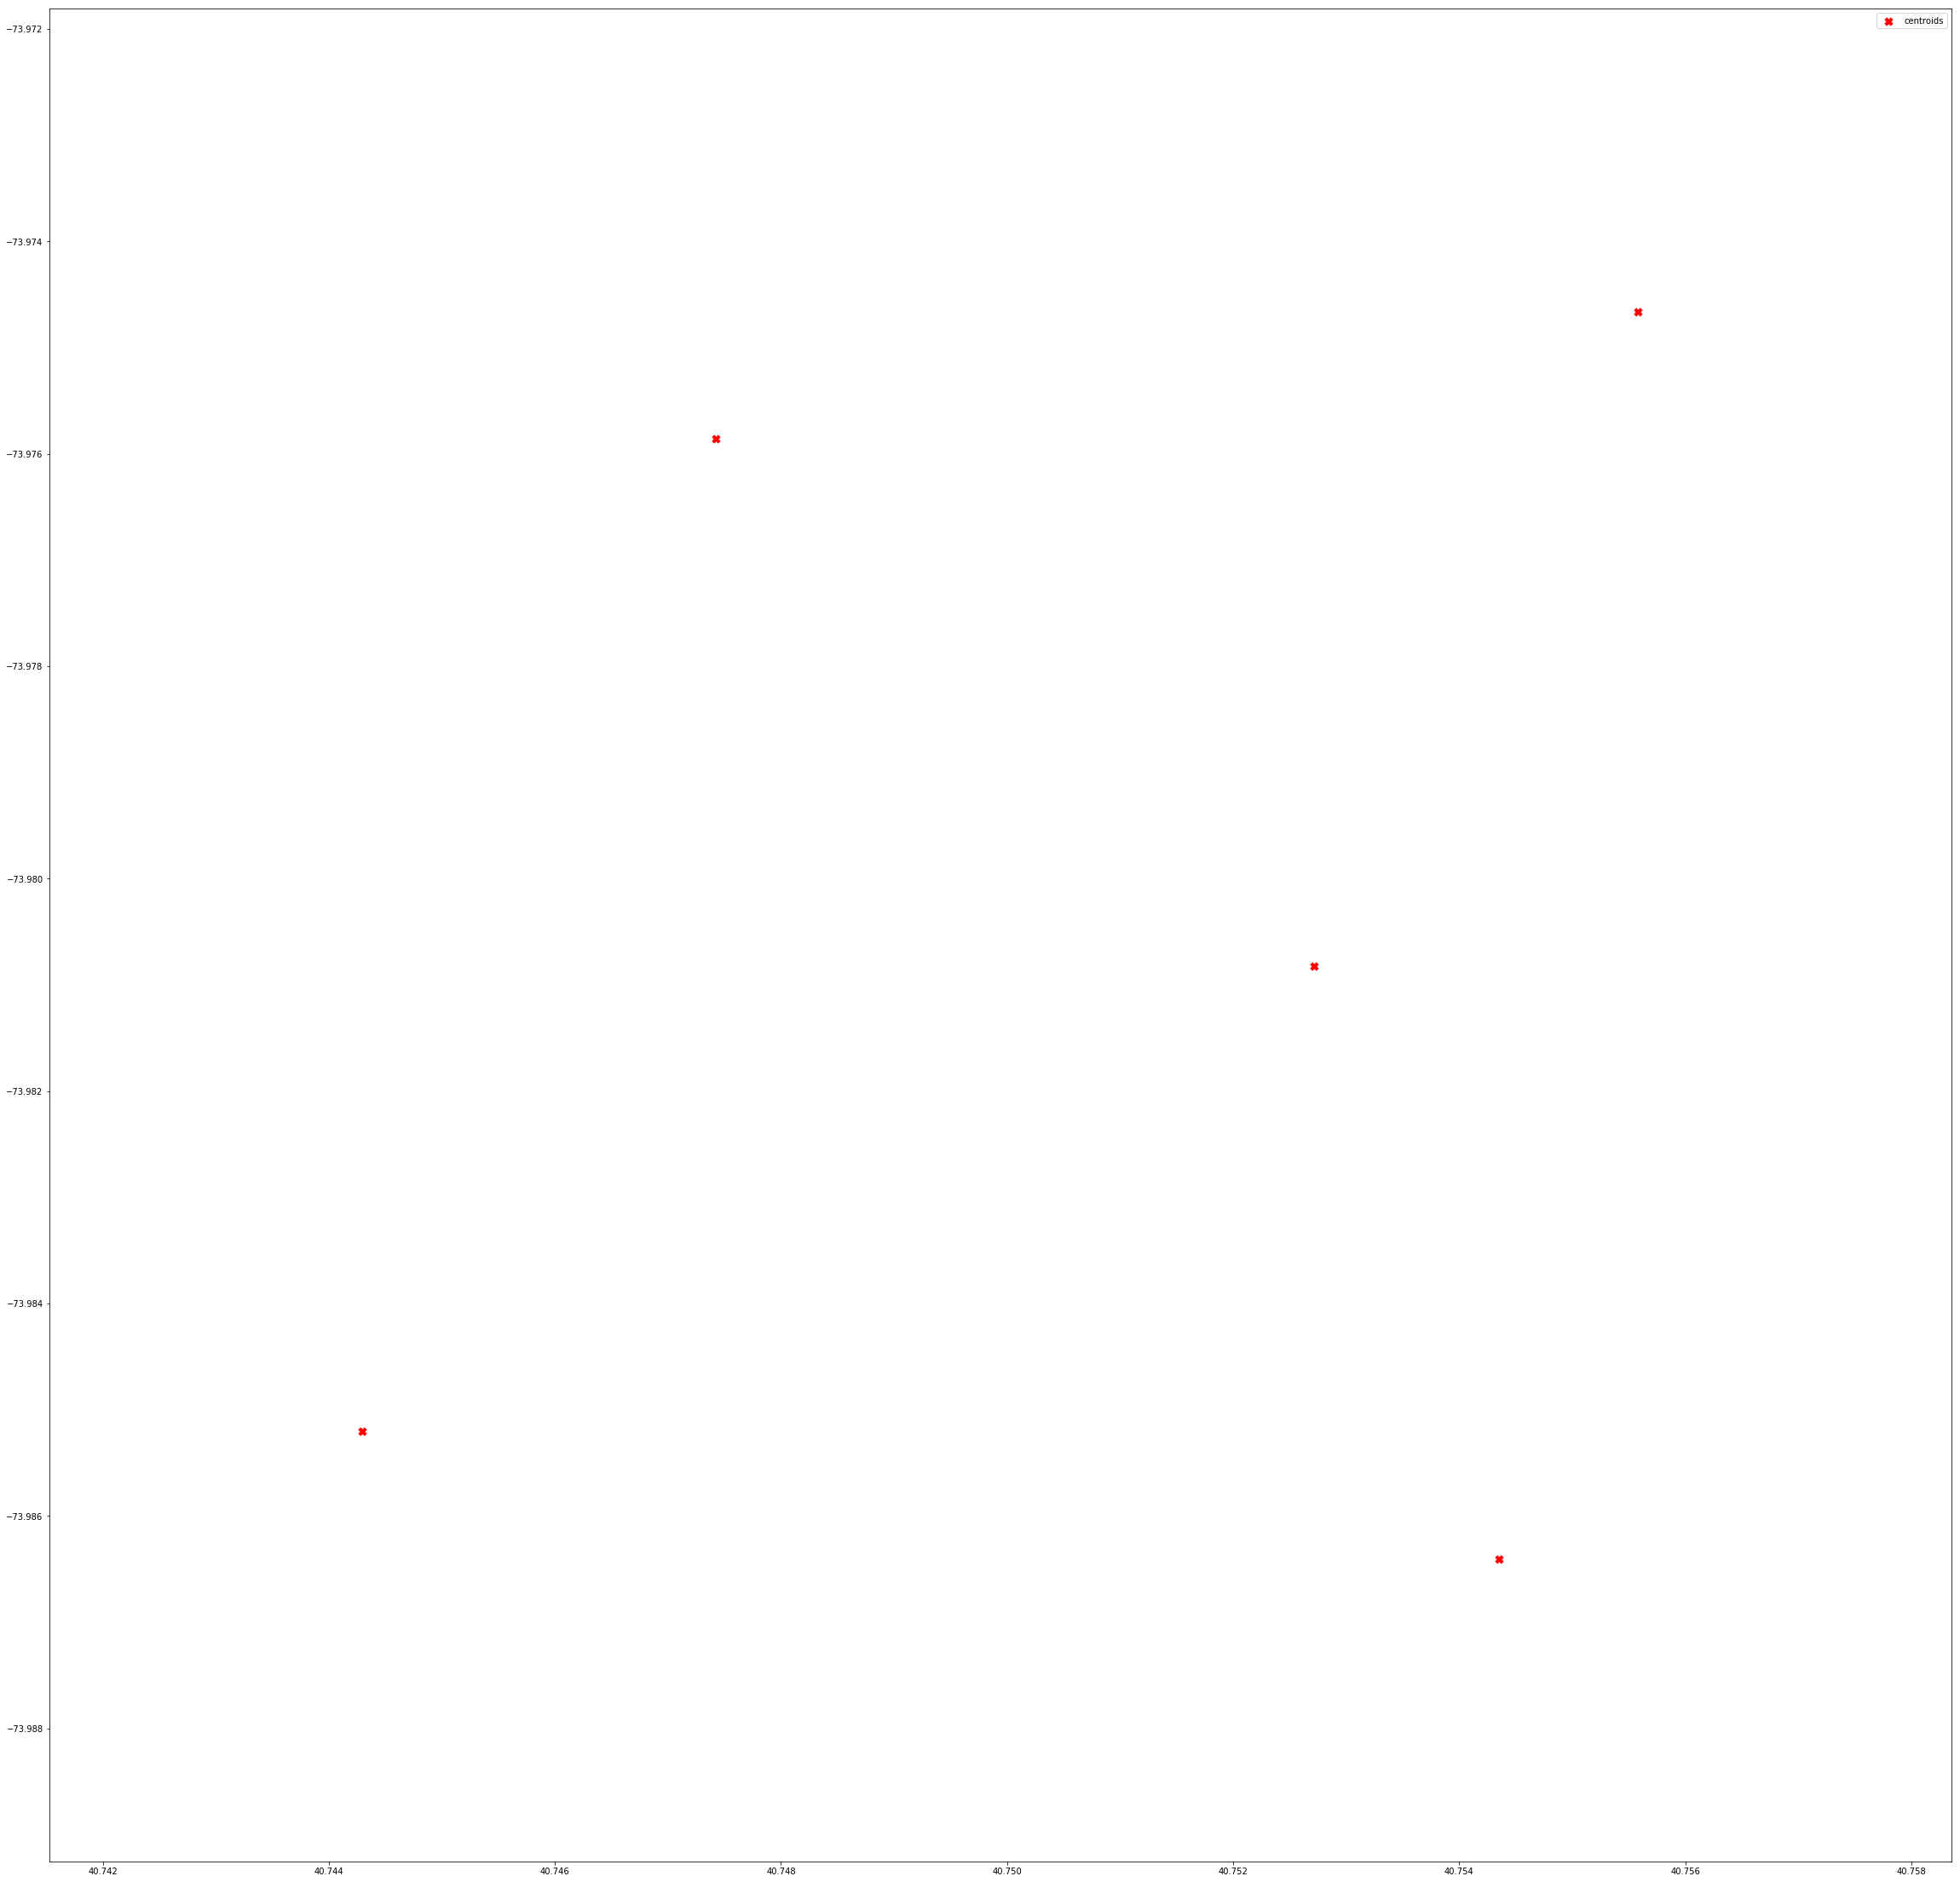

In [83]:
kMeansModelres=KMeans(n_clusters=5, init='k-means++', random_state=0).fit(res0)
plt.scatter(kMeansModelres.cluster_centers_[:,0], kMeansModelres.cluster_centers_[:,1], 
        marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()


# Notes

##  Problem Formulation
Investigating the formulation of an optimization problem. In the city, there are only a certain amount of cars that a particular block can support within a timeframe for pickups. Ultimately, the goal is to redistribute pickups by maximizing the utility of resources while minimizing Incentives (as a function of distance). [Queueing and Load balancing problem? Satsifaction= perception - expectation]
$$ f(t)=\text{max}_t (\sum_i^{n} \mu_i - \theta (d))$$
$$
\begin{equation}
\begin{aligned}
& \mu_i = c- r_i (t)\;, \text{ The Utility of Block i}\\
& c_i= 36 \text{   Block capacity for number of cars pickup slots (constant)  }\\
& r_i (t)=\text{Riders at a given block, i, as a function of time interval t}\\
& \theta(d)=\text{Incentive factor as an arbitrary linear function of distance from center}\\
\end{aligned}
\end{equation}
$$

Constraints:
Distance is one arbitrarily set to be less than or equal to 3 blocks (the greater the distance, the less effective a pickup becomes in its original purpose)
$$ d\leq 3$$

$$ r_i (t) \leq c_i$$

Decision Variables:
$$ r_i (t)\text{  to  } r_j (t)$$ 

The idea is to group pickups into blocks after converting it into addresses. 

Resarch Papers: https://ieeexplore.ieee.org/abstract/document/9464953 (https://arxiv.org/pdf/2006.07919.pdf)

-> Group rides into block buckets
-> Cluster blocks (center with the highest density)
-> Perform load balancing from center block (distribute to other 8 surrounding blocks)
Alternatively
-> Group intervals of 1hr, then cluster for each interval
-> Observe how the clusters move over the course of the day
->